## Package and Requirement Setup

In [69]:
## Needed only for execution on Colab
# from google.colab import drive
# drive.mount('/content/drive')

In [70]:
# import sys
# !pip install arviz==0.7.0
# !pip install pymc3==3.8
# !pip install Theano==1.0.4
# !pip install numpy scipy pandas
# !pip install seaborn sklearn graphviz

In [71]:
import warnings
warnings.simplefilter(action='ignore', category=FutureWarning)
warnings.simplefilter(action='ignore', category=UserWarning)

In [72]:
def initialize_plt_font(latex=False):
    import matplotlib.pyplot as plt
    import matplotlib.font_manager as fm
    import os
    fm = fm.json_load(os.path.expanduser("~/.cache/matplotlib/fontlist-v310.json"))
    # specify the custom font to use
    plt.rcParams['font.family'] = 'sans-serif'
    plt.rcParams['font.sans-serif'] = u'Helvetica'
    plt.style.use('seaborn-white')
    plt.rcParams['text.usetex'] = latex
    color = '#87ceeb'
    plt.style.use('seaborn-white')
    plt.rcParams['pdf.fonttype'] = 42
    plt.rcParams['ps.fonttype'] = 42

In [73]:
# from matplotlib import rcParams
# rcParams['font.family'] = 'sans-serif'
# rcParams['font.sans-serif'] = ['Tahoma']

In [74]:
import numpy as np
from scipy.stats import t as studentT
import pandas as pd
from theano import shared
import theano.tensor as tt
import pymc3 as pm
import seaborn as sns
import matplotlib.pyplot as plt
import sklearn
import math
import graphviz

from matplotlib import gridspec
from matplotlib.patches import Rectangle
from matplotlib.ticker import MultipleLocator, FormatStrFormatter
from matplotlib import rc
import arviz as az

from IPython.display import Image

color = '#87CEEB'
initialize_plt_font()


print('Running on PyMC3 v{}'.format(pm.__version__))

# If it is run on Colab, put the exp1_data folder in the root of your Google drive and use this data path
# DATA_PATH = "drive/My Drive/exp1_data"
# If it is run on a local machine, use the following data path
DATA_PATH = "Data"



Running on PyMC3 v3.8


## Read Data

In [75]:
likert_raw = pd.read_csv(DATA_PATH + '/ALLOCATE_LIKERT_P1.csv').sort_values(by=['userId'])
likert_raw.head()

,_id,pets,art,education,environment,health,human,international,faith,veteran,data_reason_likert_p1,time,userId
0,5e62bd916ffda4487364f749,3,3,5,5,5,5,4,2,4,I chose societal issues that have a direct imp...,16:01.8,5e62bc5def25df51135385a3
1,5e62cf03ef25df51135385b7,4,2,5,3,4,5,4,4,5,I think people over other things take priority.,30:27.7,5e62ceb06ffda4487364f75b
2,5e62d0e16ffda4487364f75e,4,4,5,5,5,5,3,3,4,I made these decisions based on what topics I ...,38:25.5,5e62cfd5ef25df51135385b9
3,5e6410c2ae7e33fbc93cdd0d,3,3,4,4,5,3,3,1,4,I want most of the money to go towards health-...,23:15.0,5e641008789957f84988d12b
4,5e641563789957f84988d143,5,5,5,5,5,5,5,5,5,All these issues are important. It’s all part...,42:59.7,5e641507ae7e33fbc93cdd19


In [76]:
likert_d_raw = pd.read_csv(DATA_PATH + '/DONATION_LIKERT.csv').sort_values(by=['userId'])
likert_d_raw.head()

,_id,donation_a_pets,donation_b_art,donation_c_education,donation_d_environment,donation_e_health,donation_f_human,donation_g_international,donation_h_faith,donation_i_veteran,time,userId
0,5e62bf3aef25df51135385a6,0,0,12,0,12,11,0,0,0,23:06.2,5e62bc5def25df51135385a3
1,5e62cf4b6ffda4487364f75c,0,0,0,0,0,0,0,0,0,31:39.6,5e62ceb06ffda4487364f75b
2,5e62d1ba6ffda4487364f75f,0,0,0,5,5,5,0,0,0,42:02.1,5e62cfd5ef25df51135385b9
3,5e6411a9789957f84988d134,0,0,0,10,10,5,0,0,10,27:05.8,5e641008789957f84988d12b
4,5e641593789957f84988d144,0,0,0,0,0,0,0,0,0,43:47.2,5e641507ae7e33fbc93cdd19


In [77]:
qv36_raw = pd.read_csv(DATA_PATH + '/QV_P1_36.csv').sort_values(by=['userId'])
qv36_raw.head()

,_id,pets,art,education,environment,health,human,international,faith,veteran,userId,time,completed
0,5e62c631ef25df51135385ae,2,0,0,5,1,2,0,0,1,5e62c4156ffda4487364f751,52:49.9,5e62c4156ffda4487364f751
1,5e63ff50b7375d865ecb6e5e,2,1,3,2,2,3,1,1,1,5e63fde404f53cb40efd2cdb,08:48.9,5e63fde404f53cb40efd2cdb
2,5e641244789957f84988d13f,1,1,0,3,2,2,2,-3,-2,5e640f2eae7e33fbc93cdd09,29:41.0,5e640f2eae7e33fbc93cdd09
3,5e6411c4789957f84988d137,1,2,2,1,3,4,1,0,0,5e640f66ae7e33fbc93cdd0b,27:32.6,5e640f66ae7e33fbc93cdd0b
4,5e6417c1789957f84988d147,1,1,3,2,3,3,1,0,1,5e64113fae7e33fbc93cdd10,53:05.3,5e64113fae7e33fbc93cdd10


In [78]:
qv36_d_raw = pd.read_csv(DATA_PATH + '/DONATION_QV36.csv').sort_values(by=['userId'])
qv36_d_raw.head()

,_id,donation_a_pets,donation_b_art,donation_c_education,donation_d_environment,donation_e_health,donation_f_human,donation_g_international,donation_h_faith,donation_i_veteran,time,userId,isQV
0,5e62c70def25df51135385af,0,0,0,5,0,0,0,0,0,56:29.8,5e62c4156ffda4487364f751,1
1,5e63ffdbb7375d865ecb6e5f,0,0,0,0,0,0,0,0,0,11:07.8,5e63fde404f53cb40efd2cdb,1
2,5e641352789957f84988d141,0,0,0,0,0,5,5,0,0,34:10.4,5e640f2eae7e33fbc93cdd09,2
3,5e6411fa789957f84988d13c,0,0,0,0,0,0,0,0,0,28:26.6,5e640f66ae7e33fbc93cdd0b,2
4,5e641842789957f84988d149,10,0,0,10,10,0,0,0,5,55:14.3,5e64113fae7e33fbc93cdd10,2


In [79]:
qv108_raw = pd.read_csv(DATA_PATH + '/QV_P1_108.csv').sort_values(by=['userId'])
qv108_raw.head()

,_id,pets,art,education,environment,health,human,international,faith,veteran,userId,time,completed
0,5e62ccb26ffda4487364f759,2,1,2,2,2,-8,-4,2,2,5e62c99c6ffda4487364f757,20:34.1,5e62c99c6ffda4487364f757
1,5e62d6c9ef25df51135385be,4,0,4,1,6,3,0,4,3,5e62d3746ffda4487364f760,03:37.4,5e62d3746ffda4487364f760
2,5e636639169182538ed7dc65,3,3,5,5,3,3,1,0,4,5e6363eaab9c7a51ed5b57e2,15:37.8,5e6363eaab9c7a51ed5b57e2
3,5e63ff8304f53cb40efd2cdd,3,2,5,2,2,5,2,3,2,5e63fde404f53cb40efd2cdb,09:39.9,5e63fde404f53cb40efd2cdb
4,5e641183ae7e33fbc93cdd12,2,3,3,2,4,8,1,0,0,5e640f66ae7e33fbc93cdd0b,26:27.5,5e640f66ae7e33fbc93cdd0b


In [80]:
qv108_d_raw = pd.read_csv(DATA_PATH + '/DONATION_QV108.csv').sort_values(by=['userId'])
qv108_d_raw.head()

,_id,donation_a_pets,donation_b_art,donation_c_education,donation_d_environment,donation_e_health,donation_f_human,donation_g_international,donation_h_faith,donation_i_veteran,time,userId,isQV,Unnamed: 13
0,5e62cde36ffda4487364f75a,10,0,0,0,0,0,0,5,5,25:39.2,5e62c99c6ffda4487364f757,2,5e62c99c6ffda4487364f757
1,5e62d7fdef25df51135385bf,2,0,0,0,5,5,0,0,5,08:45.6,5e62d3746ffda4487364f760,1,5e62d3746ffda4487364f760
2,5e636716ab9c7a51ed5b57e6,3,1,10,15,2,2,0,0,2,19:18.7,5e6363eaab9c7a51ed5b57e2,1,5e6363eaab9c7a51ed5b57e2
3,5e63ffdbb7375d865ecb6e5f,0,0,0,0,0,0,0,0,0,11:07.8,5e63fde404f53cb40efd2cdb,2,5e63fde404f53cb40efd2cdb
4,5e6411fa789957f84988d13c,0,0,0,0,0,0,0,0,0,28:26.6,5e640f66ae7e33fbc93cdd0b,1,5e640f66ae7e33fbc93cdd0b


In [81]:
qv324_raw = pd.read_csv(DATA_PATH + '/QV_P1_324.csv').sort_values(by=['userId'])
qv324_raw.head()

,_id,pets,art,education,environment,health,human,international,faith,veteran,userId,time,completed
0,5e62c6856ffda4487364f755,5,2,3,13,6,5,6,0,4,5e62c4156ffda4487364f751,54:13.6,5e62c4156ffda4487364f751
1,5e62cc696ffda4487364f758,7,3,3,2,3,-12,-5,3,4,5e62c99c6ffda4487364f757,19:21.1,5e62c99c6ffda4487364f757
2,5e62d7496ffda4487364f763,6,0,7,3,12,4,0,5,6,5e62d3746ffda4487364f760,05:45.1,5e62d3746ffda4487364f760
3,5e63669a169182538ed7dc66,5,5,9,9,7,4,3,0,5,5e6363eaab9c7a51ed5b57e2,17:14.3,5e6363eaab9c7a51ed5b57e2
4,5e6411e9789957f84988d139,5,6,4,7,7,6,5,-7,-4,5e640f2eae7e33fbc93cdd09,28:09.9,5e640f2eae7e33fbc93cdd09


In [82]:
qv324_d_raw = pd.read_csv(DATA_PATH + '/DONATION_QV324.csv').sort_values(by=['userId'])
qv324_d_raw.head()

,_id,donation_a_pets,donation_b_art,donation_c_education,donation_d_environment,donation_e_health,donation_f_human,donation_g_international,donation_h_faith,donation_i_veteran,time,userId,isQV,Unnamed: 13
0,5e62c70def25df51135385af,0,0,0,5,0,0,0,0,0,56:29.8,5e62c4156ffda4487364f751,2,5e62c4156ffda4487364f751
1,5e62cde36ffda4487364f75a,10,0,0,0,0,0,0,5,5,25:39.2,5e62c99c6ffda4487364f757,1,5e62c99c6ffda4487364f757
2,5e62d7fdef25df51135385bf,2,0,0,0,5,5,0,0,5,08:45.6,5e62d3746ffda4487364f760,2,5e62d3746ffda4487364f760
3,5e636716ab9c7a51ed5b57e6,3,1,10,15,2,2,0,0,2,19:18.7,5e6363eaab9c7a51ed5b57e2,2,5e6363eaab9c7a51ed5b57e2
4,5e641352789957f84988d141,0,0,0,0,0,5,5,0,0,34:10.4,5e640f2eae7e33fbc93cdd09,1,5e640f2eae7e33fbc93cdd09


In [83]:
vote_columns = ['pets','art','education','environment','health','human','international','faith','veteran']
donate_columns = ['donation_a_pets','donation_b_art','donation_c_education','donation_d_environment','donation_e_health','donation_f_human','donation_g_international','donation_h_faith','donation_i_veteran']

likert = likert_raw[vote_columns].to_numpy() - 3 # Likert survey, normalized to -2 to 2
likert_d = likert_d_raw[donate_columns].to_numpy() # Likert donation

qv36 = qv36_raw[vote_columns].to_numpy() # QV36 survey
qv36_d = qv36_d_raw[donate_columns].to_numpy() # QV36 donation

qv108 = qv108_raw[vote_columns].to_numpy() # QV108 survey
qv108_d = qv108_d_raw[donate_columns].to_numpy() # QV108 donation

qv324 = qv324_raw[vote_columns].to_numpy() # QV324 survey
qv324_d = qv324_d_raw[donate_columns].to_numpy() # QV324 donation


In [84]:
# Function to remove participants with zero total donation
def filter_nonzero(survey_data, donation_data):
    d_bool = (np.sum(donation_data, axis=1) != 0)
    survey_f = survey_data[d_bool]
    donation_f = donation_data[d_bool]
    return survey_f, donation_f

In [85]:
# Function to normalize donation relative to the total donation amount, between 0 to 1
def normalize_donation_to_proportion(donation_data):
    donation_sum = np.sum(donation_data, axis=1)[:,None]
    donation_data_norm = donation_data/donation_sum
    return donation_data_norm

In [86]:
# Remove participants with zero total donation and normalize donation amount 
likert_f, likert_d_f = filter_nonzero(likert, likert_d)
likert_d_f_norm = normalize_donation_to_proportion(likert_d_f)

qv36_f, qv36_d_f = filter_nonzero(qv36, qv36_d)
qv36_d_f_norm = normalize_donation_to_proportion(qv36_d_f)

qv108_f, qv108_d_f = filter_nonzero(qv108, qv108_d)
qv108_d_f_norm = normalize_donation_to_proportion(qv108_d_f)

qv324_f, qv324_d_f = filter_nonzero(qv324, qv324_d)
qv324_d_f_norm = normalize_donation_to_proportion(qv324_d_f)

In [87]:
print('Number of records for non-zero donation likert & Percentage of non-zero donation')
print(likert_f.shape)
print(likert_f.shape[0]/likert.shape[0])

print('Number of records for non-zero donation qv36 & Percentage of non-zero donation')
print(qv36_f.shape)
print(qv36_f.shape[0]/qv36.shape[0])

print('Number of records for non-zero donation qv108 & Percentage of non-zero donation')
print(qv108_f.shape)
print(qv108_f.shape[0]/qv108.shape[0])

print('Number of records for non-zero donation qv324 & Percentage of non-zero donation')
print(qv324_f.shape)
print(qv324_f.shape[0]/qv324.shape[0])

Number of records for non-zero donation likert & Percentage of non-zero donation
(44, 9)
0.7857142857142857
Number of records for non-zero donation qv36 & Percentage of non-zero donation
(76, 9)
0.7102803738317757
Number of records for non-zero donation qv108 & Percentage of non-zero donation
(76, 9)
0.7037037037037037
Number of records for non-zero donation qv324 & Percentage of non-zero donation
(84, 9)
0.7567567567567568


## Descriptive Statistics

### Total donation amount across groups

In [88]:
# Total donation amount
likert_d_sum = np.sum(likert_d_f, axis=1)[:,None]
qv36_d_sum = np.sum(qv36_d_f, axis=1)[:,None]
qv108_d_sum = np.sum(qv108_d_f, axis=1)[:,None]
qv324_d_sum = np.sum(qv324_d_f, axis=1)[:,None]

In [89]:
# Function to add "category" column to a numpy array and convert to a dataframe
def np_add_category(data, group, cols):
  l = data.shape[0]
  condition = pd.DataFrame([group] * l, columns=['condition'])
  df = pd.DataFrame(data, columns=cols)
  cond_df = pd.concat([df, condition], axis=1)
  return cond_df

In [90]:
likert_d_sum_df = np_add_category(likert_d_sum, 'likert', ['value'])
qv36_d_sum_df = np_add_category(qv36_d_sum, 'qv36', ['value'])
qv108_d_sum_df = np_add_category(qv108_d_sum, 'qv108', ['value'])
qv324_d_sum_df = np_add_category(qv324_d_sum, 'qv324', ['value'])

In [91]:
# Combine all groups into one df
d_sum = pd.concat([likert_d_sum_df, qv36_d_sum_df, qv108_d_sum_df, qv324_d_sum_df], axis=0)

In [92]:
# Bin total donation amount
def bin_donation(row):
    if row['value'] <= 4:
        return '1-4'
    elif 4 < row['value'] <= 8:
        return '5-8'
    elif 8 < row['value'] <= 12:
        return '9-12'
    elif 12 < row['value'] <= 16:
        return '13-16'
    elif 16 < row['value'] <= 20:
        return '17-20'  
    elif 20 < row['value'] <= 24:
        return '21-24'
    elif 24 < row['value'] <= 28:
        return '25-28'
    elif 28 < row['value'] <= 32:
        return '29-32'    
    else:
        return '33-35'

d_sum['bin_donation'] = d_sum.apply(bin_donation, axis=1)

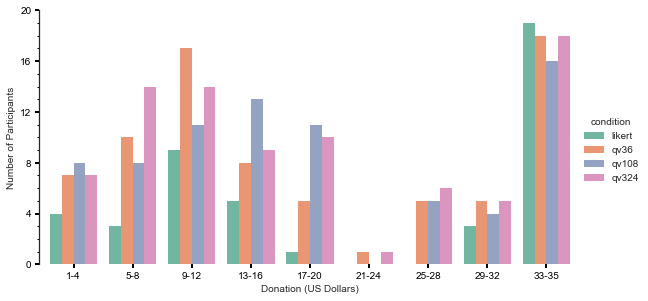

In [93]:
# Plot and compare total donation amount across groups
g = sns.catplot(
    hue="condition",
    data=d_sum,
    hue_order=["likert", "qv36", "qv108", "qv324"],
    height=4,
    x="bin_donation",
    order=['1-4', '5-8', '9-12', '13-16', '17-20', '21-24', '25-28', '29-32', '33-35'],
    kind="count",
    palette="Set2",
    aspect=2).set(yticks=np.arange(0, 21, 4)).set_axis_labels(
        "Donation (US Dollars)", "Number of Participants")

majorLocator = MultipleLocator(4) 
minorLocator = MultipleLocator(2)

g.ax.yaxis.set_major_locator(majorLocator)
g.ax.yaxis.set_minor_locator(minorLocator)

g.ax.tick_params(direction='out', length=4, width=2, colors='k', which='major')
g.ax.tick_params(
    direction='out', length=2, width=1, colors='k', which='minor', bottom=False)
g.ax.minorticks_on()
g.despine(offset=5, left=False, bottom=True, trim=True)
g.savefig("total_contributions_across_conditions.pdf")

### Donation across topics across groups

In [94]:
# Donation amount across topics aggregated in Likert, QV36, QV108, and QV324 samples respectively
likert_d_topic = np.sum(likert_d_f, axis=0)[:,None] / np.sum(likert_d_f) * 100
qv36_d_topic = np.sum(qv36_d_f, axis=0)[:,None] / np.sum(qv36_d_f) * 100
qv108_d_topic = np.sum(qv108_d_f, axis=0)[:,None] / np.sum(qv108_d_f) * 100
qv324_d_topic = np.sum(qv324_d_f, axis=0)[:,None] / np.sum(qv324_d_f) * 100

# Add topic as a column to the array for plotting purpose
likert_d_topic = np.concatenate((likert_d_topic, np.asarray(vote_columns).reshape(9,1)), axis=1)
qv36_d_topic = np.concatenate((qv36_d_topic, np.asarray(vote_columns).reshape(9,1)), axis=1)
qv108_d_topic = np.concatenate((qv108_d_topic, np.asarray(vote_columns).reshape(9,1)), axis=1)
qv324_d_topic = np.concatenate((qv324_d_topic, np.asarray(vote_columns).reshape(9,1)), axis=1)
print(likert_d_topic.shape)

(9, 2)


In [95]:
# Add condition column as category info for plotting purpose
likert_d_topic_df = np_add_category(likert_d_topic, 'likert', ['value', 'topic'])
qv36_d_topic_df = np_add_category(qv36_d_topic, 'qv36', ['value', 'topic'])
qv108_d_topic_df = np_add_category(qv108_d_topic, 'qv108', ['value', 'topic'])
qv324_d_topic_df = np_add_category(qv324_d_topic, 'qv324', ['value', 'topic'])

In [96]:
# Combine all groups into one df
d_topic = pd.concat([likert_d_topic_df, qv36_d_topic_df, qv108_d_topic_df, qv324_d_topic_df], axis=0)
d_topic['value'] = d_topic['value'].astype('float')

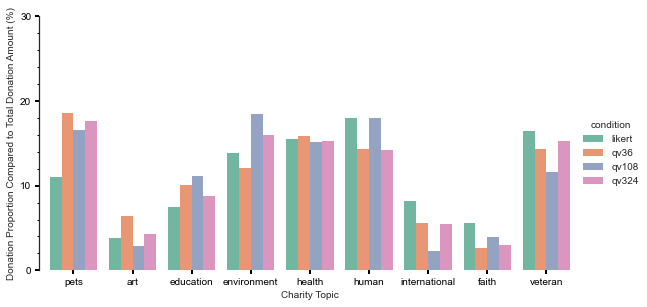

In [97]:
# Plot and compare aggregated donation amount across topics across groups
g = sns.catplot(
    hue="condition",
    data=d_topic,
    hue_order=["likert", "qv36", "qv108", "qv324"],
    height=4,
    x="topic",
    y="value",
    kind="bar",
    palette="Set2",
    aspect=2).set(yticks=np.arange(0, 31, 10)).set_axis_labels(
       "Charity Topic", "Donation Proportion Compared to Total Donation Amount (%)")

majorLocator = MultipleLocator(10) 
minorLocator = MultipleLocator(2)

g.ax.yaxis.set_major_locator(majorLocator)
g.ax.yaxis.set_minor_locator(minorLocator)

g.ax.tick_params(direction='out', length=4, width=2, colors='k', which='major')
g.ax.tick_params(
    direction='out', length=2, width=1, colors='k', which='minor', bottom=False)
g.ax.minorticks_on()
g.despine(offset=5, left=False, bottom=True, trim=True)

g.savefig("normalized_contributions_per_topic_across_conditions.pdf")

### Survey response distributions

In [98]:
# Add "id" column to a df
def add_id_column(df):
  l = df.shape[0]
  id_col = pd.DataFrame(range(l), columns=['ID'])
  df_ind = pd.concat([id_col, df], axis=1)
  return df_ind

In [99]:
# Add "category" column to a df
def df_add_category(data, group, cols):
  l = data.shape[0]
  condition = pd.DataFrame([group] * l, columns=['condition'])
  cond_df = pd.concat([data, condition], axis=1)
  return cond_df

In [100]:
# Add "id" and "category" column to the survey response dataframe
likert_df = pd.DataFrame(likert_f, columns=vote_columns)
likert_ind = add_id_column(likert_df)
likert_melt = pd.melt(likert_ind, id_vars=['ID'], value_vars=vote_columns,
        var_name='topic', value_name='vote')
likert_melt_df = df_add_category(likert_melt, 'likert', ["ID"] + vote_columns)
likert_melt_df_n = likert_melt_df.copy()
likert_melt_df_n['vote'] = likert_melt_df_n['vote'] / 2

qv36_df = pd.DataFrame(qv36_f, columns=vote_columns)
qv36_ind = add_id_column(qv36_df)
qv36_melt = pd.melt(qv36_ind, id_vars=['ID'], value_vars=vote_columns,
        var_name='topic', value_name='vote')
qv36_melt_df = df_add_category(qv36_melt, 'qv36', ["ID"] + vote_columns)
qv36_melt_df_n = qv36_melt_df.copy()
qv36_melt_df_n['vote'] = qv36_melt_df_n['vote'] / 6

qv108_df = pd.DataFrame(qv108_f, columns=vote_columns)
qv108_ind = add_id_column(qv108_df)
qv108_melt = pd.melt(qv108_ind, id_vars=['ID'], value_vars=vote_columns,
        var_name='topic', value_name='vote')
qv108_melt_df = df_add_category(qv108_melt, 'qv108', ["ID"] + vote_columns)
qv108_melt_df_n = qv108_melt_df.copy()
qv108_melt_df_n['vote'] = qv108_melt_df_n['vote'] / 11

qv324_df = pd.DataFrame(qv324_f, columns=vote_columns)
qv324_ind = add_id_column(qv324_df)
qv324_melt = pd.melt(qv324_ind, id_vars=['ID'], value_vars=vote_columns,
        var_name='topic', value_name='vote')
qv324_melt_df = df_add_category(qv324_melt, 'qv324', ["ID"] + vote_columns)
qv324_melt_df_n = qv324_melt_df.copy()
qv324_melt_df_n['vote'] = qv324_melt_df_n['vote'] / 18


In [101]:
# Combine all groups into one df
qv_vote_topic = pd.concat([qv36_melt_df, qv108_melt_df, qv324_melt_df], axis=0)

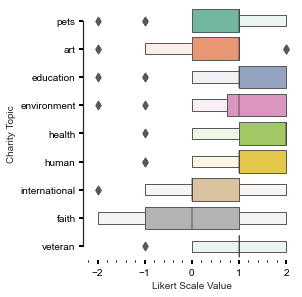

In [102]:
# Plot and compare vote distribution across topics for the Likert condition
g = sns.catplot(
    data=likert_melt_df,
    height=4,
    x="vote",
    y='topic',
    kind="boxen",
    palette="Set2",
    aspect=1).set(xticks=np.arange(-2, 3, 1)).set_axis_labels(
       "Likert Scale Value", "Charity Topic")

majorLocator = MultipleLocator(1) 
minorLocator = MultipleLocator(0.2)

g.ax.xaxis.set_major_locator(majorLocator)
g.ax.xaxis.set_minor_locator(minorLocator)

g.ax.tick_params(direction='out', length=4, width=2, colors='k', which='major')
g.ax.tick_params(
    direction='out', length=2, width=1, colors='k', which='minor', left=False)
g.ax.minorticks_on()
g.despine(offset=5, left=False, bottom=True, trim=True)

g.savefig("likert_distribution_per_topic.pdf")

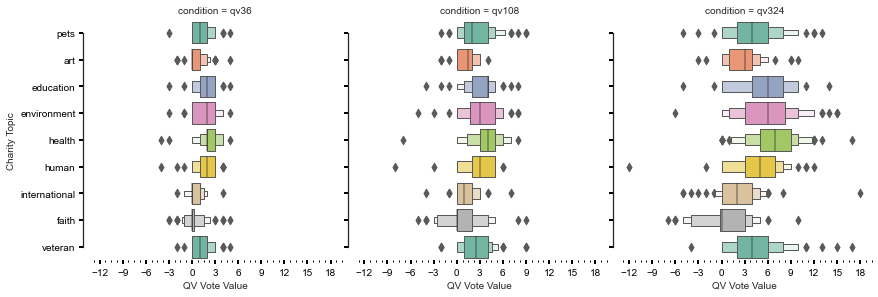

In [35]:
# Plot and compare vote distribution across topics for different QV conditions
g = sns.catplot(
    data=qv_vote_topic,
    height=4,
    col='condition',
    x="vote",
    y='topic',
    kind="boxen",
    palette="Set2",
    aspect=1).set_axis_labels(
       "QV Vote Value", "Charity Topic")

for i in range(3):
  g.axes[0,i].set(xticks=np.arange(-12, 19, 3))
  g.axes[0,i].xaxis.set_major_locator(MultipleLocator(3))
  g.axes[0,i].xaxis.set_minor_locator(MultipleLocator(1))
  g.axes[0,i].tick_params(direction='out', length=4, width=2, colors='k', which='major')
  g.axes[0,i].tick_params(
      direction='out', length=2, width=1, colors='k', which='minor', left=False)
  g.axes[0,i].minorticks_on()

g.despine(offset=5, left=False, bottom=True, trim=True)

g.savefig("qv_distribution_per_topic.pdf")

### Covariate between Votes and Normalized Donation

In [36]:
# Add "id" and "category" columns to donation dataframe
likert_d_df = pd.DataFrame(likert_d_f_norm, columns=vote_columns)
likert_d_ind = add_id_column(likert_d_df)
likert_d_melt = pd.melt(likert_d_ind, id_vars=['ID'], value_vars=vote_columns,
        var_name='topic', value_name='donation')

qv36_d_df = pd.DataFrame(qv36_d_f_norm, columns=vote_columns)
qv36_d_ind = add_id_column(qv36_d_df)
qv36_d_melt = pd.melt(qv36_d_ind, id_vars=['ID'], value_vars=vote_columns,
        var_name='topic', value_name='donation')

qv108_d_df = pd.DataFrame(qv108_d_f_norm, columns=vote_columns)
qv108_d_ind = add_id_column(qv108_d_df)
qv108_d_melt = pd.melt(qv108_d_ind, id_vars=['ID'], value_vars=vote_columns,
        var_name='topic', value_name='donation')

qv324_d_df = pd.DataFrame(qv324_d_f_norm, columns=vote_columns)
qv324_d_ind = add_id_column(qv324_d_df)
qv324_d_melt = pd.melt(qv324_d_ind, id_vars=['ID'], value_vars=vote_columns,
        var_name='topic', value_name='donation')


In [37]:
# Combine votes and donation data into one DF
likert_melt_vd = pd.concat([likert_melt_df_n, likert_d_melt['donation']], axis=1)

qv36_melt_vd = pd.concat([qv36_melt_df_n, qv36_d_melt['donation']], axis=1)

qv108_melt_vd = pd.concat([qv108_melt_df_n, qv108_d_melt['donation']], axis=1)

qv324_melt_vd = pd.concat([qv324_melt_df_n, qv324_d_melt['donation']], axis=1)


In [38]:
# Combine different conditions into one DF
all_melt_vd = pd.concat([likert_melt_vd, qv36_melt_vd, qv108_melt_vd, qv324_melt_vd], axis=0)

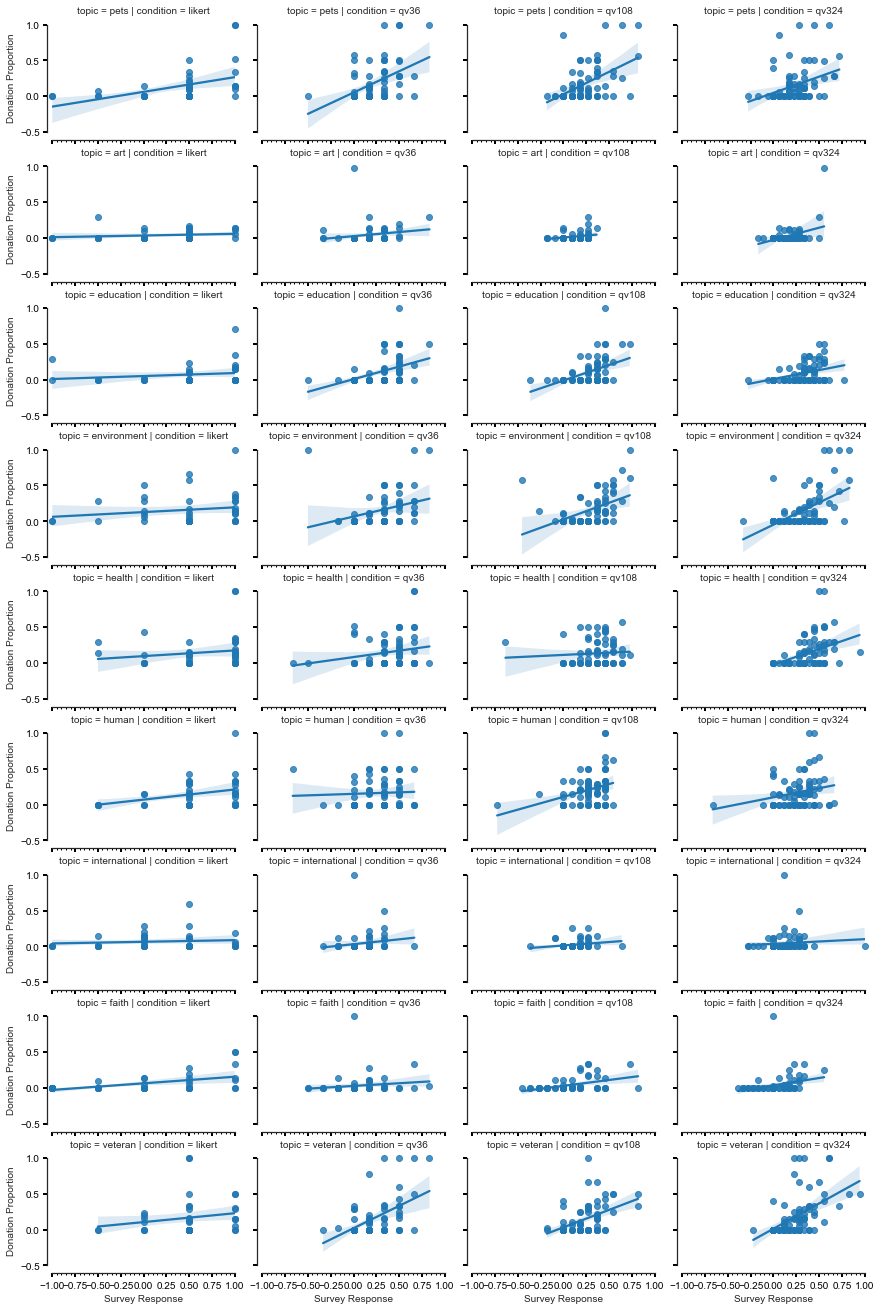

In [60]:
# Plot and compare vote distribution across topics for likert
g = sns.lmplot(
    data=all_melt_vd,
    height=2,
    scatter_kws={'clip_on':False},
    x="vote",
    y='donation',
    row='topic',
    col='condition',
    palette="Set2",
    aspect=1.5).set_axis_labels(
       "Survey Response", "Donation Proportion")

for i in range(9):
  for j in range(4):
    g.axes[i,j].set(xticks=np.arange(-1, 1.1, 0.25))
    g.axes[i,j].tick_params(direction='out', length=4, width=2, colors='k', which='major')
    g.axes[i,j].tick_params(
        direction='out', length=2, width=1, colors='k', which='minor', left=False)
    g.axes[i,j].minorticks_on()

g.despine(offset=5, left=False, bottom=False, trim=True)

g.savefig("vote_donation_covariates.pdf")

### Budget Usage

In [40]:
# Calculate percentage credit budget used in QV across groups
qv36_b = np.sum(qv36_f**2, axis=1)[:,None] / 36 * 100
qv108_b = np.sum(qv108_f**2, axis=1)[:,None] / 108 * 100
qv324_b = np.sum(qv324_f**2, axis=1)[:,None] / 324 * 100

In [41]:
# Add "category" column for plotting purpose
qv36_b_df = np_add_category(qv36_b, 'qv36', ['value'])
qv108_b_df = np_add_category(qv108_b, 'qv108', ['value'])
qv324_b_df = np_add_category(qv324_b, 'qv324', ['value'])

In [42]:
# Combine all groups into one df
qv_b = pd.concat([qv36_b_df, qv108_b_df, qv324_b_df], axis=0)

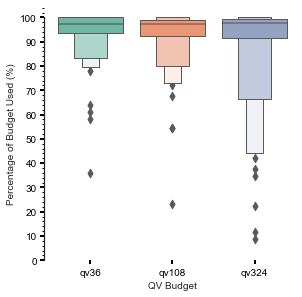

In [43]:
# Plot and compare budget usage distribution for qv
g = sns.catplot(
    data=qv_b,
    height=4,
    x="condition",
    y='value',
    kind="boxen",
    palette="Set2",
    aspect=1).set(yticks=np.arange(0, 101, 10)).set_axis_labels(
       "QV Budget", "Percentage of Budget Used (%)")

majorLocator = MultipleLocator(10) 
minorLocator = MultipleLocator(2)

g.ax.yaxis.set_major_locator(majorLocator)
g.ax.yaxis.set_minor_locator(minorLocator)

g.ax.tick_params(direction='out', length=4, width=2, colors='k', which='major')
g.ax.tick_params(
    direction='out', length=2, width=1, colors='k', which='minor', bottom=False)
g.ax.minorticks_on()
g.despine(offset=5, left=False, bottom=True, trim=True)

g.savefig("qv_budget_used_distribution.pdf")

## Alignment Analysis on an Individual Level Using Similarity Angle Theta

In [44]:
# Dataframe with number of votes on each option
likert_df = pd.DataFrame(likert_f, columns=vote_columns)
qv36_df = pd.DataFrame(qv36_f, columns=vote_columns)
qv108_df = pd.DataFrame(qv108_f, columns=vote_columns)
qv324_df = pd.DataFrame(qv324_f, columns=vote_columns)

# Dataframe with donation normalized in proportion
likert_d_df = pd.DataFrame(likert_d_f_norm, columns=donate_columns)
qv36_d_df = pd.DataFrame(qv36_d_f_norm, columns=donate_columns)
qv108_d_df = pd.DataFrame(qv108_d_f_norm, columns=donate_columns)
qv324_d_df = pd.DataFrame(qv324_d_f_norm, columns=donate_columns)

# Concatenate votes and normalized donation in one dataframe
likert_vd = pd.concat([likert_df, likert_d_df], axis=1)
qv36_vd = pd.concat([qv36_df, qv36_d_df], axis=1)
qv108_vd = pd.concat([qv108_df, qv108_d_df], axis=1)
qv324_vd = pd.concat([qv324_df, qv324_d_df], axis=1)


In [45]:
# Function that calculates the theta angle in cosine similarity
def cosine_sim_theta(vd_data, dim):
  vd_np = np.asarray(vd_data)
  nr, _ = vd_np.shape
  thetas = []
  for i in range(nr):
    cos_sim = np.inner(vd_np[i, :dim], vd_np[i, dim:]) / (np.linalg.norm(vd_np[i, :dim]) * np.linalg.norm(vd_np[i, dim:]))
    theta = math.acos(cos_sim) / math.pi * 180
    thetas.append(theta)

  return thetas

In [46]:
# Calculate cosine similarity angle theta between survey results and normalized donation amount
likert_thetas = cosine_sim_theta(likert_vd, 9)
qv36_thetas = cosine_sim_theta(qv36_vd, 9)
qv108_thetas = cosine_sim_theta(qv108_vd, 9)
qv324_thetas = cosine_sim_theta(qv324_vd, 9)

## Bayesian Analysis Helper Functions

In [47]:
# Helper function from https://github.com/JWarmenhoven/DBDA-python
# Calculate Gamma shape and rate from mode and sd.
# if using gamma prior for the class dependent sigma

def gammaShRaFromModeSD(mode, sd):
    rate = (mode + np.sqrt(mode**2 + 4 * sd**2)) / (2 * sd**2)
    shape = 1 + mode * rate
    return (shape, rate)

In [48]:
# Setting up our Bayesian model as specified in the paper
def studentT_alignment_nd_indep(all_df):
  x = all_df.condition.cat.codes.values
  y = all_df.thetas
  # missing = y.isnull()
  # print(y[missing])

  # 0 - likert, 1 - QV108, 2 - QV324, 3 - QV36

  yMean = y.mean()
  ySD = y.std()
  NxLvl = len(all_df.condition.cat.categories)

  aGammaShRa = gammaShRaFromModeSD(ySD/2, 2*ySD)
  normalSigma = ySD * 100

  with pm.Model() as studentT_theta:
      mu = pm.Normal('mu', mu=yMean, sd=normalSigma, shape=NxLvl)

      ySigma = pm.Gamma('sigma', alpha=2, beta=0.1, shape=NxLvl)

      nu_minus1 = pm.Exponential('nu_minus1', 1/29.)
      nu = pm.Deterministic('nu', nu_minus1+1)
      studentT = pm.StudentT('y', nu=nu, mu=mu[x], sd=ySigma[x], observed=y)

      start = pm.find_MAP()
      trace_thetas = pm.sample(4000, tune=6000, start=start)

  return trace_thetas, studentT_theta

In [49]:
# Function to add "category" column to the thetas dataset
def df_add_category(thetas, group):
  l = len(thetas)
  condition = [group] * l
  thetas_array = {'thetas':thetas,'condition':condition}
  thetas_df = pd.DataFrame(thetas_array)
  return thetas_df

In [50]:
# Helper function to visualize if the thetas in Bayesian simulation process 
# follow a studentT distribution as we assumed in the model
# Function from https://github.com/JWarmenhoven/DBDA-python
def plot_mustache_studentT(var, sd, j, degree_f, axis, col, width=.75):
    for i in np.arange(start=0, stop=len(var), step=int(len(var) * .05)):
        rv = studentT(loc=var[i], scale=sd[i], df=degree_f[i])
        yrange = np.linspace(rv.ppf(0.01), rv.ppf(0.99), 100)
        xrange = rv.pdf(yrange)

        # When the SD of a group is large compared to others, then the top of its mustache is relatively
        # low and does not plot well together with low SD groups.
        # Scale the xrange so that the 'height' of the all mustaches is 0.75
        xrange_scaled = xrange * (width / xrange.max())

        # Using the negative value to flip the mustache in the right direction.
        axis.plot(-xrange_scaled + j, yrange, color=col, alpha=.6)

In [51]:
# Function to visualize if the thetas in Bayesian simulation process 
# follow a studentT distribution as we assumed in the model
def pred_posterior_plot(trace, df, title, col):
    # Here we plot the metric predicted variable for each group. Then we superimpose the
    # posterior predictive distribution

    # In the trace, mean has the name "mu", std has the name 'sigma', and degree of freedom has the name 'nu'
    # In the df (observed data), values have the column name "thetas", and group category has the column name "condition"

    likert_post = trace['mu'][:, 0]
    qv108_post = trace['mu'][:, 1]
    qv324_post = trace['mu'][:, 2]
    qv36_post = trace['mu'][:, 3]
    scale = trace['sigma'][:]
    d_f = trace['nu']

    fig, ax = plt.subplots(1, 1, figsize=(8, 5))
    ax.set_title(title + ' Data with Posterior Predictive Distribution')

    sns.swarmplot(
        'condition',
        'thetas',
        data=df,
        order=["likert","qv36", "qv108", "qv324"],
    #     color="white",
    #     edgecolor="gray",
        ax=ax)
    ax.set_xlim(xmin=-1)

    for i, grp in enumerate([likert_post, qv36_post, qv108_post, qv324_post]):
        sd = trace['sigma'][:,i]
        # plotting mustaches with the student t; the original function uses a normal dist
        plot_mustache_studentT(var=grp, sd=sd, j=i, degree_f=d_f, axis=ax, col=col, width=0.65)

    z = ax
    z.yaxis.set_major_formatter(FormatStrFormatter('%.2f'))
    z.tick_params(direction='in', length=6, width=2, colors='k', which='major')
    z.tick_params(
        direction='in', length=4, width=1, colors='k', which='minor', bottom=False)
    z.yaxis.set_ticks_position('left')
    z.spines['right'].set_visible(False)
    z.spines['top'].set_visible(False)
    z.spines['left'].set_visible(False)
    z.spines['bottom'].set_visible(False)
    z.spines['bottom'].set_position(('outward', 10))

    z.minorticks_on()

    fig.savefig(title + "_data_with_StudentT_posterior_predictions.pdf")
    fig.show()

In [52]:
# A function to plot the absolute effect and normalized effect size of comparison between conditions
def plot_effect_size_dist(trace, title, col):
    # In the trace, mean has the name "mu", std has the name 'sigma', and degree of freedom has the name 'nu'
    fig, axes = plt.subplots(2, 7, figsize=(20, 6))

    likert_post = trace['mu'][:, 0]
    qv108_post = trace['mu'][:, 1]
    qv324_post = trace['mu'][:, 2]
    qv36_post = trace['mu'][:, 3]
    scale = trace['sigma'][:]

    contrasts = [
        likert_post - qv36_post, 
        likert_post - qv108_post, 
        likert_post - qv324_post,
        qv36_post - qv108_post,
        qv36_post - qv324_post,
        qv108_post - qv324_post,
        likert_post - np.mean([qv36_post, qv108_post, qv324_post], axis=0)
    ]

    cscale = np.zeros((len(likert_post), 7))
    cscale[:, 0] = np.sqrt((scale[:, 0]**2 + scale[:, 3]**2) / 2)  # likert_post - qv36_post
    cscale[:, 1] = np.sqrt((scale[:, 0]**2 + scale[:, 1]**2) / 2)  # likert_post - qv108_post
    cscale[:, 2] = np.sqrt((scale[:, 0]**2 + scale[:, 2]**2) / 2)  # likert_post - qv324_post
    cscale[:, 3] = np.sqrt((scale[:, 3]**2 + scale[:, 1]**2) / 2)  # qv36_post - qv108_post
    cscale[:, 4] = np.sqrt((scale[:, 3]**2 + scale[:, 2]**2) / 2)  # qv36_post - qv324_post
    cscale[:, 5] = np.sqrt((scale[:, 1]**2 + scale[:, 2]**2) / 2)  # qv108_post - qv324_post

    t = np.sqrt((scale[:, 1]**2 + scale[:, 2]**2 + scale[:, 3]**2) / 9)  # variance of mean of qv36_post, qv108_post, qv324_post
    cscale[:, 6] = np.sqrt(
        (t**2 + scale[:, 0]**2) / 2)  # variance of mean of qv36_post, qv108_post, qv324_post - likert_post

    sd = [cscale[:,0],
          cscale[:,1],
          cscale[:,2],
          cscale[:,3],
          cscale[:,4],
          cscale[:,5],
          cscale[:,6]
    ]

    contrast_titles = [
        'likert \n vs \n qv36', 
        'likert \n vs \n qv108',
        'likert \n vs \n qv324', 
        'qv36 \n vs \n qv108',
        'qv36 \n vs \n qv324',
        'qv108 \n vs \n qv324',
        'likert \n vs \n qv overall'
    ]

    for contr, csd, ctitle, ax_top, ax_bottom in zip(contrasts, sd, contrast_titles,
                                                fig.axes[:7], fig.axes[7:]):
        pm.plot_posterior(contr, ref_val=0, 
                          color=col, 
                          point_estimate='mode',
                          # alpha_level=0.03,
                          textsize=10,
                          round_to=2,
                          ax=ax_top,
                          kind='hist')
        pm.plot_posterior(contr / csd, ref_val=0, 
                          color=col, 
                          point_estimate='mode',
                          # alpha_level=0.03,
                          textsize=10,
                          round_to=2,
                          ax=ax_bottom,
                          kind='hist') # use this!!
    #     pm.plot_posterior(contr, ref_val=0, color=col, ax=ax_bottom)
        ax_top.set_title(ctitle)
        ax_bottom.set_title(ctitle)
        
        ax_top.set_xlabel('Difference')
        ax_bottom.set_xlabel('Effect Size')
        
        ax_top.xaxis.set_major_formatter(FormatStrFormatter('%.2f'))
        ax_bottom.xaxis.set_major_formatter(FormatStrFormatter('%.2f'))
        
        ax_top.tick_params(direction='out', length=6, width=2, colors='k', which='major')
        ax_bottom.tick_params(direction='out', length=6, width=2, colors='k', which='major')
        
        ax_top.tick_params(direction='out', length=4, width=1, colors='k', which='minor')
        ax_bottom.tick_params(direction='out', length=4, width=1, colors='k', which='minor')
        
        ax_top.xaxis.set_ticks_position('bottom')
        ax_bottom.xaxis.set_ticks_position('bottom')
        
        ax_top.minorticks_on()
        ax_bottom.minorticks_on()
        

    fig.tight_layout()
    fig.savefig(title + "_StudentT_differences_and_effects.pdf")
    fig.show()

In [53]:
# Function to plot the traceplot for the MCMC estimation of the Bayesian model 
# varnames is a list of variable names as defined in the model trace
# title_names is a list of variable names in latex format that you want to display
def my_traceplots(varnames, title_names, trace, model_name):
    
  
  NRows = len(varnames) # variables to show
  NCols = 2
  fig, axs = sns.mpl.pyplot.subplots(NRows, NCols)

  fig.set_size_inches(NCols*9, NRows*2)


  pm.traceplot(trace, 
              varnames=varnames, 
              combined=True,
              ax=axs);


  for i in range(NRows):
      for j in range(NCols):
          z = axs[i, j]
          z.set_xlabel("") # no individual labels
          z.set_ylabel("")
          z.spines['right'].set_visible(False)
          z.spines['top'].set_visible(False)
          z.spines['left'].set_visible(False)
          z.spines['bottom'].set_visible(False)
          z.spines['bottom'].set_position(('outward', 10))
          z.yaxis.set_visible(True)
          z.xaxis.set_major_formatter(FormatStrFormatter('%.2f'))
          z.yaxis.set_major_formatter(FormatStrFormatter('%.2f'))
          z.tick_params(direction='in', length=6, width=2, colors='k', which='major')
          z.tick_params(direction='in', length=4, width=1, colors='gray', which='minor')
          z.minorticks_on()

  # # axs[3,0].set_xscale('log')
  # # axs[3,1].set_yscale('log')

  for i in range(NRows):
    # axs[i,0].set_title(r('$' + title_names[i] + '$'), size=16)
    # axs[i,1].set_title(r('$' + title_names[i] + '$'), size=16)
    axs[i,0].set_title(title_names[i], size=16)
    axs[i,1].set_title(title_names[i], size=16)

  plt.subplots_adjust(hspace=0.5,
                      wspace=0.1)

  fig.savefig(model_name + '_traceplot.pdf')

## Bayesian Analysis

In [62]:
# Enable true if want latex output
latex = True
initialize_plt_font(latex)

# Add "category" column for the cosine similarity thetas between survey results and normalized donation
likert_thetas_df = df_add_category(likert_thetas, 'likert')
qv36_thetas_df = df_add_category(qv36_thetas, 'qv36')
qv108_thetas_df = df_add_category(qv108_thetas, 'qv108')
qv324_thetas_df = df_add_category(qv324_thetas, 'qv324')

all_vd_theta = pd.concat([likert_thetas_df, qv36_thetas_df, qv108_thetas_df, qv324_thetas_df], axis=0)
all_vd_theta_not_missing = all_vd_theta.thetas.notnull()
all_vd_theta = all_vd_theta[all_vd_theta_not_missing]

all_vd_theta['condition'] = all_vd_theta['condition'].astype('category')
all_vd_theta.condition.value_counts()

# there is a missing value in qv108
# missing = qv108_thetas_df.thetas.isnull()
# print(qv108_thetas_df.thetas[missing])

qv324     84
qv36      76
qv108     76
likert    44
Name: condition, dtype: int64

logp = -1,241.4, ||grad|| = 0.0060879: 100%|██████████| 42/42 [00:00<00:00, 1586.28it/s]  
Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (4 chains in 4 jobs)
NUTS: [nu_minus1, sigma, mu]
Sampling 4 chains, 0 divergences: 100%|██████████| 40000/40000 [00:43<00:00, 925.39draws/s] 


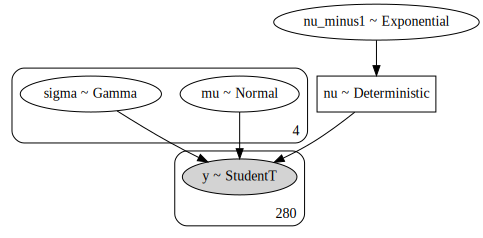

In [63]:
trace_vd_theta, model_vd_theta = studentT_alignment_nd_indep(all_vd_theta)
pm.model_to_graphviz(model_vd_theta)

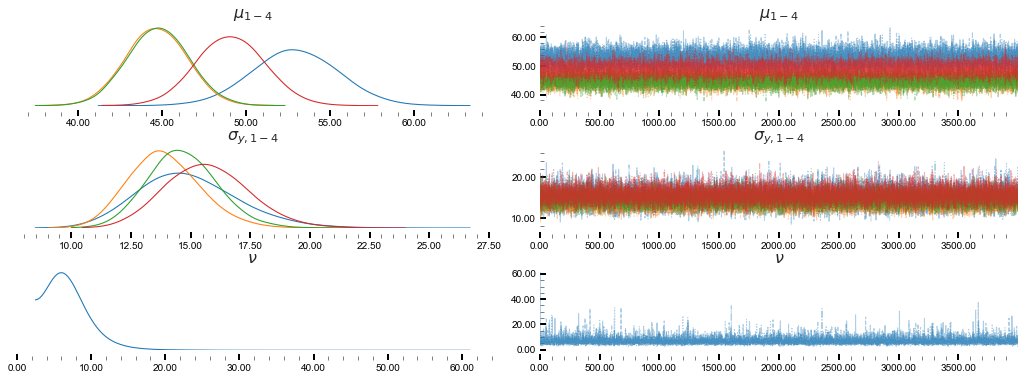

In [103]:
# Version with latex expression
# my_traceplots(['mu', 'sigma', 'nu'], ['\mu_{1-4}', '\sigma_{y, 1-4}', '\nu'], trace_vd_theta, "StudentTIndep")
my_traceplots(['mu', 'sigma', 'nu'], ["$\mu_{1-4}$", "$\sigma_{y, 1-4}$", r'$\nu$'], trace_vd_theta, "StudentTIndep_VN")

# Version without latex expression
# my_traceplots(['mu', 'sigma', 'nu'], ['mu', 'sigma', 'nu'], trace_vd_theta, "StudentTIndep")

In [57]:
az_vd_theta = az.from_pymc3(trace=trace_vd_theta)
vd_theta_summary = az.summary(az_vd_theta)
vd_theta_summary

,mean,sd,hpd_3%,hpd_97%,mcse_mean,mcse_sd,ess_mean,ess_sd,ess_bulk,ess_tail,r_hat
mu[0],52.889,2.513,48.157,57.621,0.019,0.013,18413.0,18400.0,18440.0,11635.0,1.0
mu[1],44.632,1.791,41.235,47.929,0.013,0.009,19412.0,19377.0,19420.0,13212.0,1.0
mu[2],44.765,1.824,41.454,48.341,0.013,0.009,18983.0,18983.0,18973.0,12579.0,1.0
mu[3],49.083,1.995,45.366,52.877,0.015,0.010,18606.0,18567.0,18634.0,12554.0,1.0
sigma[0],14.896,2.066,11.243,18.866,0.016,0.012,16328.0,15658.0,16735.0,12035.0,1.0
sigma[1],13.921,1.488,11.303,16.861,0.012,0.008,16629.0,16403.0,16725.0,13258.0,1.0
sigma[2],14.685,1.464,11.935,17.414,0.011,0.008,17511.0,17427.0,17466.0,12834.0,1.0
sigma[3],15.674,1.731,12.601,19.060,0.013,0.009,17602.0,17334.0,17735.0,13270.0,1.0
nu_minus1,6.020,2.679,2.322,10.635,0.025,0.018,11948.0,10501.0,13581.0,11914.0,1.0
nu,7.020,2.679,3.322,11.635,0.025,0.018,11948.0,10591.0,13581.0,11914.0,1.0


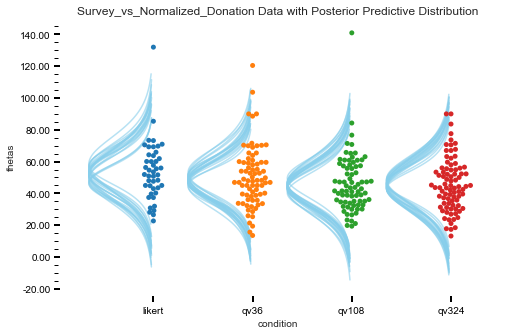

In [58]:
pred_posterior_plot(trace_vd_theta, all_vd_theta, 'Survey_vs_Normalized_Donation', color)

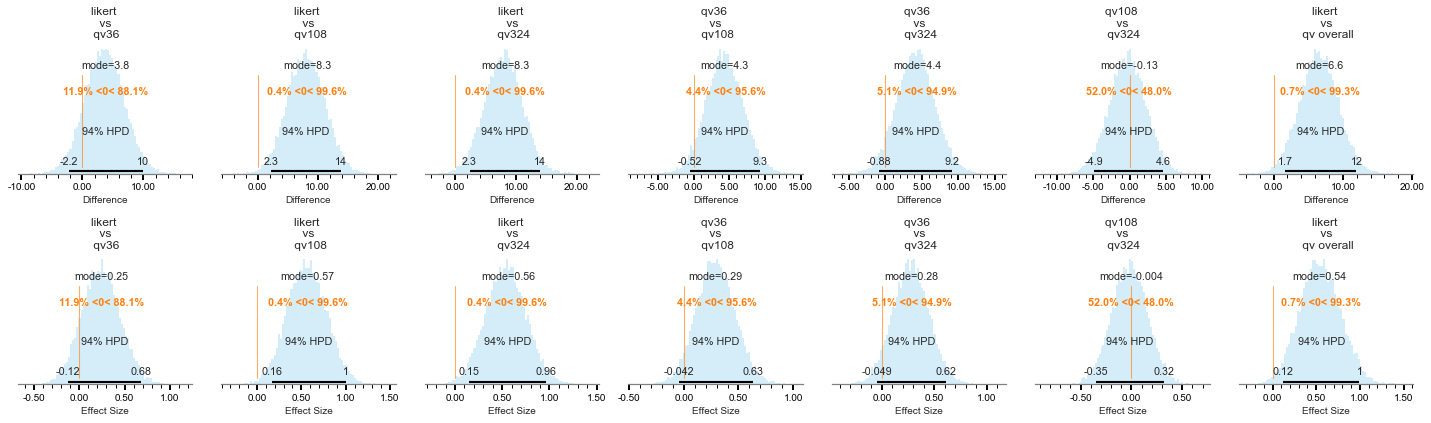

In [59]:
plot_effect_size_dist(trace_vd_theta, 'Survey_vs_Normalized_Donation', color)